# Cointegration Mean Reversion Pairs Trading
## 1. Dependencies

In [214]:
# zipline's magic command for enabling support to run in jupyter notebook
%load_ext zipline
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

from alphatools.research import get_pricing


The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


## 2. Get data
I am using Alphatools and Zipline to get my data. Alphatools only works for python 2  

In [218]:
START_DATE = pd.to_datetime('2016-6-1')#pd.datetime(2007,1,3)
END_DATE = pd.to_datetime('2016-12-30')
stock_x, stock_y = 'CVX', 'XOM'
df = get_pricing([stock_x, stock_y], START_DATE, END_DATE)
df = df.rename(lambda col: col.symbol.encode('UTF-8'), axis='columns')

## 2. Check for cointegration 
The null hyposthesis of `coint` is that the stocks are not cointegrated. The null hypothesis can be rejected if the p-value below 0.05 

In [219]:
_, p_value, _ = coint(df[stock_x], df[stock_y])
if p_value < 0.05:
    print('{0} and {1} are cointegrated!'.format(stock_x, stock_y))
else:
    print('{0} and {1} are NOT cointegrated!'.format(stock_x, stock_y))

CVX and XOM are NOT cointegrated!


## 3. Plot stationary linear combination of stocks

<IPython.core.display.Javascript object>


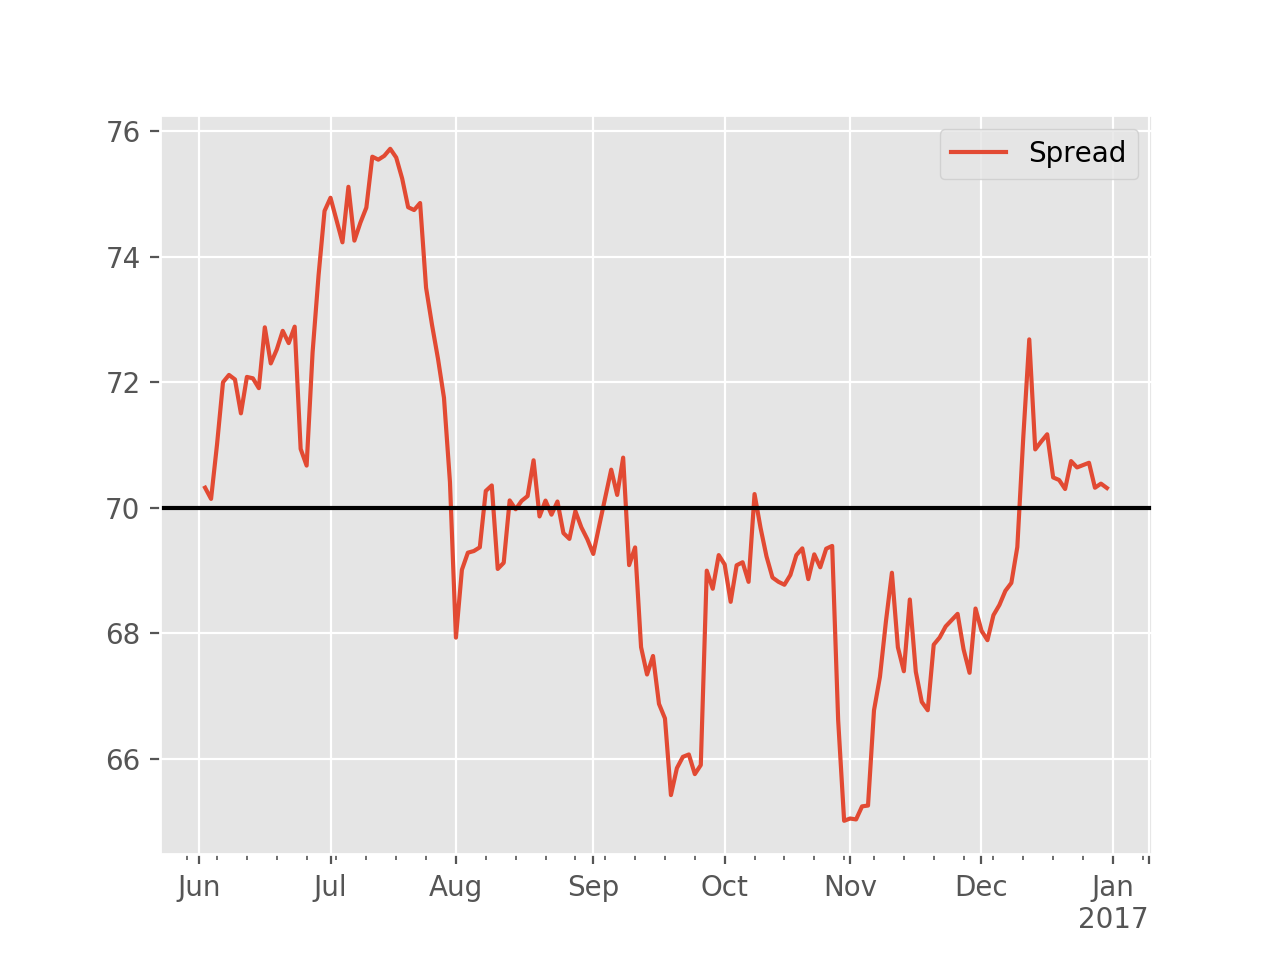

In [220]:
X, Y = df[stock_x], df[stock_y]

def get_beta(X, Y):
    stock_x = X.name
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    X = X[stock_x]
    return model.params[stock_x]

beta = get_beta(X,Y)
spread = Y - beta * X
plt.figure()
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

<IPython.core.display.Javascript object>


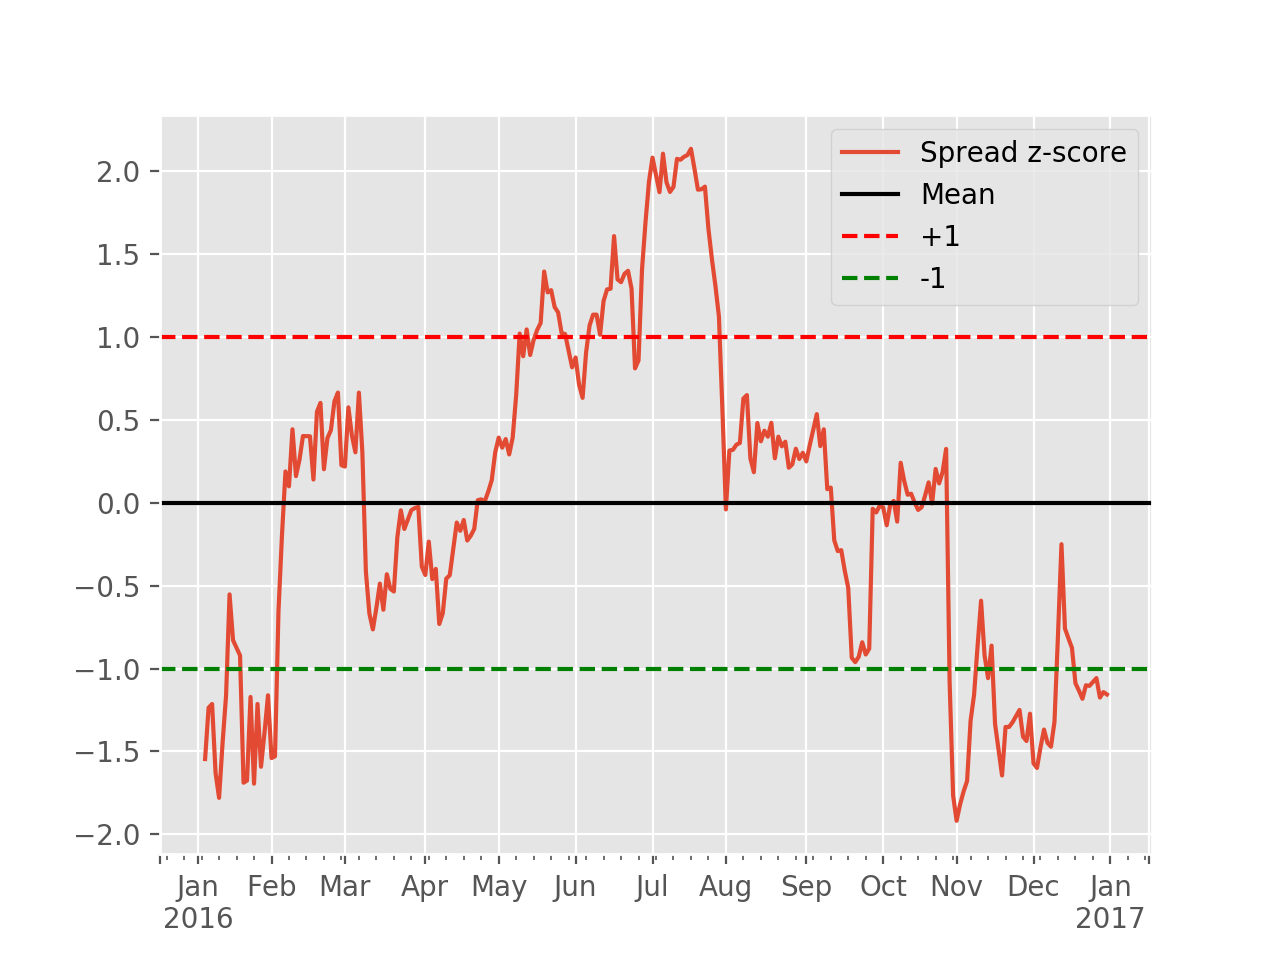

In [104]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

plt.figure()
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
plt.show()

## Backtest with zipline

In [221]:
from zipline import run_algorithm
from zipline.api import symbol, date_rules, time_rules, order_target_percent

def initialize(context):
    context.pair = (symbol(stock_x), symbol(stock_y))
    
    context.z_signal = 2
    context.z_exit = 0
    context.lookback = 200 # used for regression
    #context.z_window = 20 # used for zscore calculation, must be <= lookback
    context.status = 'flat'
    
    context.target_weights = { k: 0 for k in context.pair}
    
    # schedule to execute strategy 30 minutes before close
    schedule_function(func=check_pair_status, date_rule=date_rules.every_day(), time_rule=time_rules.market_close(minutes=30))
    
def check_pair_status(context, data):
    
    prices = data.history(context.pair, 'price', 35, '1d').iloc[-context.lookback::]
    
    new_spreads = np.ndarray((len(context.pair), 1))
    

    stock_x, stock_y = context.pair
    
    Y = prices[stock_y]
    X = prices[stock_x]
    
    beta = get_beta(X, Y) 

    spread = Y - beta * X

    z = zscore(spread)[-1]
    
    # short spread
    if z > context.z_signal and not context.status == 'short':
        context.target_weights[stock_x] = -0.5 # short top
        context.target_weights[stock_y] = 0.5 # long bottom
        context.status = 'short'
            
    # long spread
    elif z < -context.z_signal and not context.status == 'long':
        context.target_weights[stock_x] = 0.5 # long top
        context.target_weights[stock_y] = -0.5 # short bottom
        context.status = 'long'
            
    # exit case
    elif abs(z) < context.z_exit:
        context.target_weights[stock_x] = 0 # close out
        context.target_weights[stock_y] = 0 # close out
        context.status = 'flat'
    record('zscore', z)
        
    for ticker, weight in context.target_weights.items():
        order_target_percent(ticker, weight)

<IPython.core.display.Javascript object>


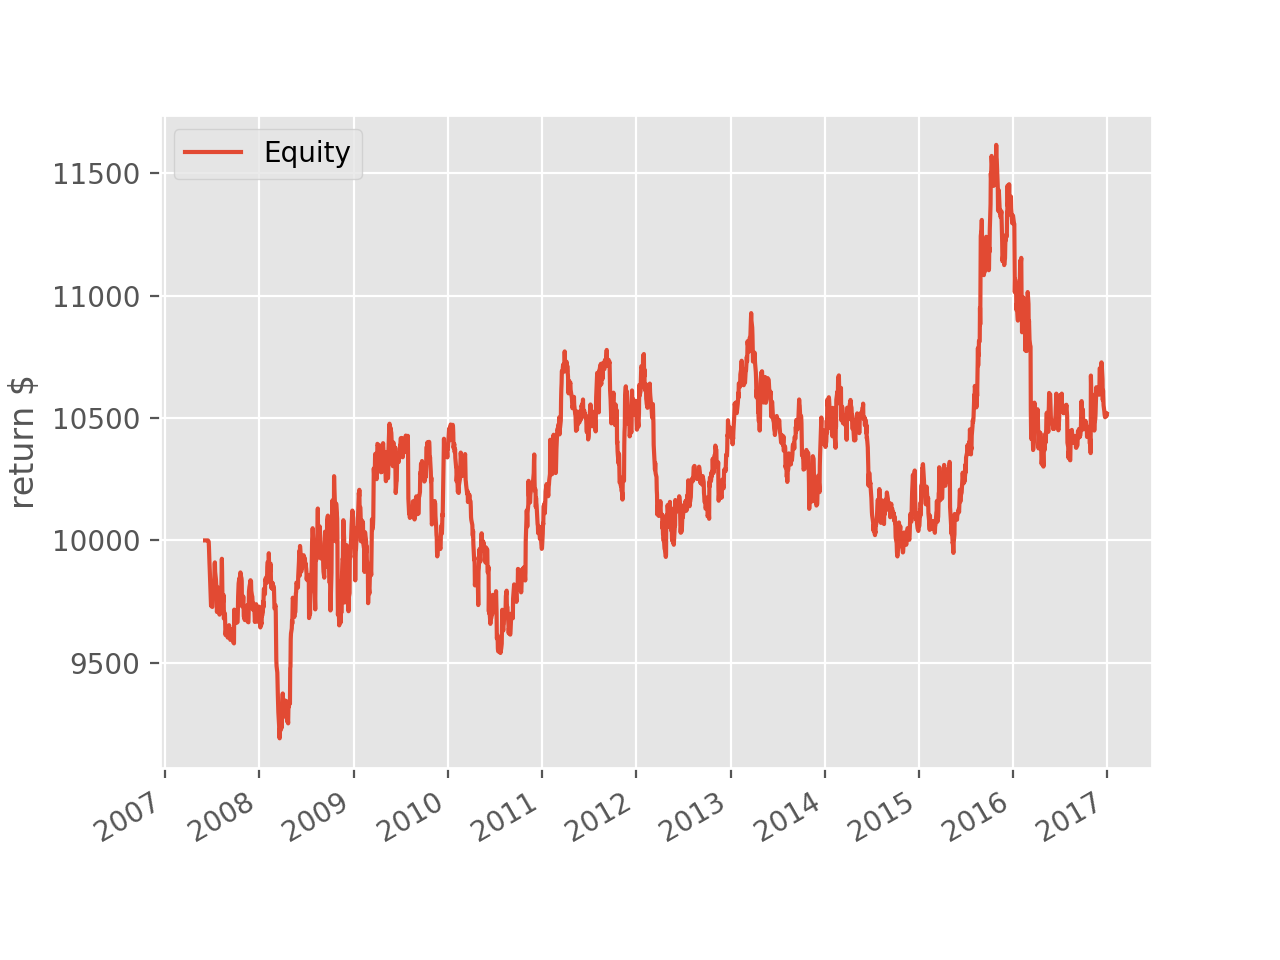

<IPython.core.display.Javascript object>


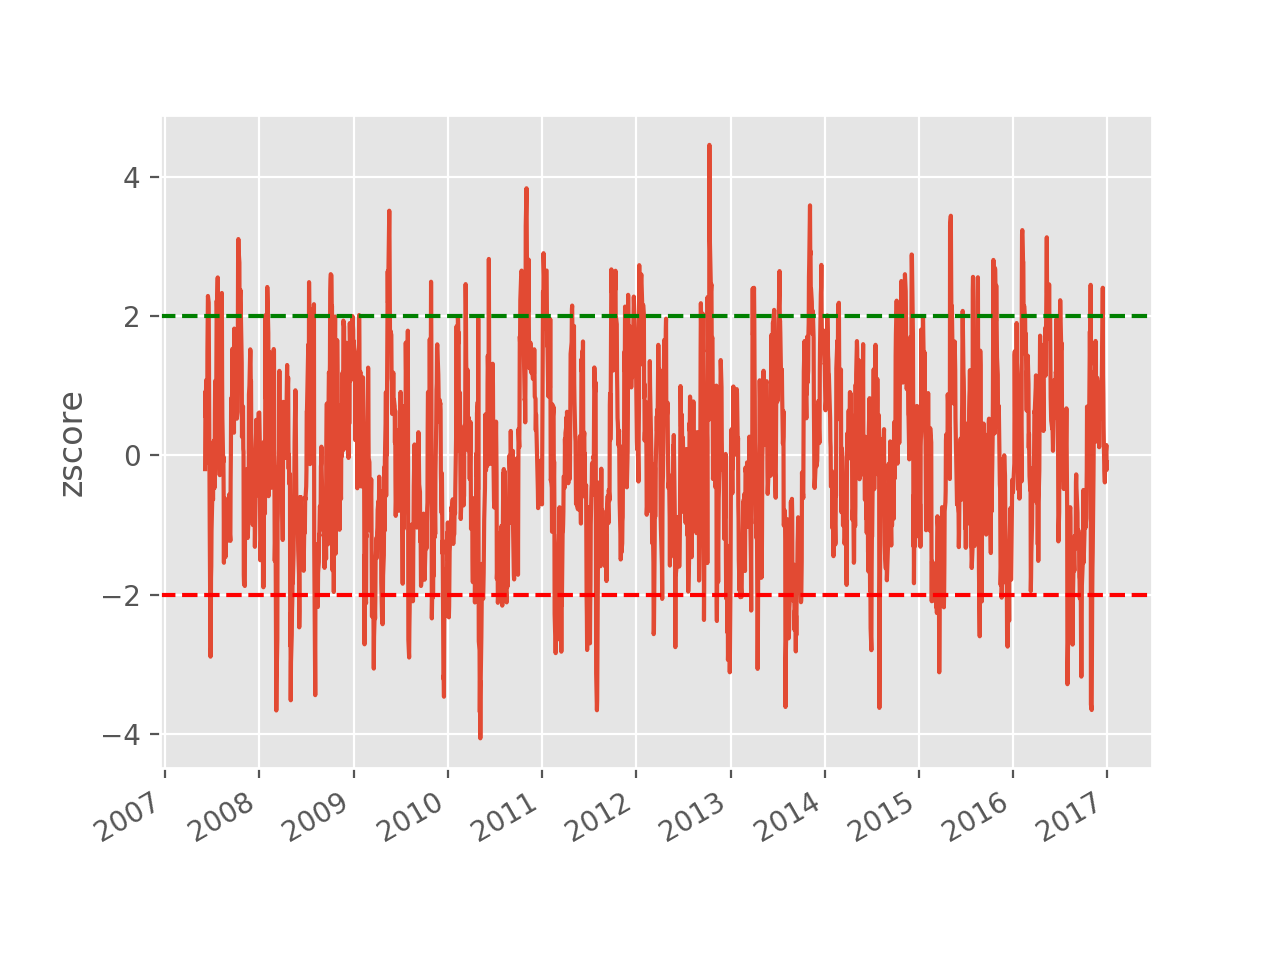

In [227]:
START_DATE = pd.to_datetime('2007-6-3')
END_DATE = pd.to_datetime('2016-12-30')
perf = run_algorithm(
    initialize=initialize,
    data_frequency='daily',
    capital_base=10000,
    bundle='quantopian-quandl',
    start=START_DATE.tz_localize('US/Eastern'),
    end=END_DATE.tz_localize('US/Eastern'))

plt.figure()
perf.portfolio_value.plot()
plt.legend(['Equity']);
plt.ylabel('return $')
plt.show()

plt.figure()
perf.zscore.plot()
plt.axhline(2, color='green', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.ylabel('zscore')
plt.show()